### About

The goal of the project was to analyze a network through metrics and **networkx visualzation**. The data in this project was manually recorded from an on-campus instagram community in an excel file and then converted into a csv to create a **pandas** dataframe. In **data transformation**, I used **regular expression** to create lists of users and tags and create edges between accounts that tag each other. This was considered a connection and useful for our analysis. We also gave accounts labels based on if they were a photography account or registered student organization to explain different activity. These labels are represented on the final graph as corresponding colors. The size of the node represents degree centrality. The most significant finding from this project is that photographer accounts are very connected and act as bridges between different subnetworks. Photography on campus may be a great way grow online presence and build connections in a college community.

In [16]:
import pandas as pd
import itertools
import networkx as nx
import re

### Reading in Data

In [17]:
df = pd.read_csv('InstagramData.csv')
df.head()

,User ID,Content tags,Date
0,@hyggediaryy,"@lifebysophia, @haku_thedoodle",4/1/2024
1,@lifebysophia,@hyggediaryy,4/1/2024
2,@haku_thedoodle,@hyggediaryy,9/4/2023
3,@shotfromdeep,@nathan_hongk,3/25/2024
4,@snipyang,"@pengflick, @mcnd_official, @kfuseent\n\n",2/14/2024


### Data Transformation

In [18]:
pattern = re.compile(r'@([a-zA-Z0-9_]+)')

df['tag_list'] = df['Content tags'].apply(lambda x: pattern.findall(str(x)))
df['User'] = df['User ID'].apply(lambda x: pattern.findall(str(x)))
df['account_list'] = df['User'] + df['tag_list']
print(df['account_list'][:5])

0       [hyggediaryy, lifebysophia, haku_thedoodle]
1                       [lifebysophia, hyggediaryy]
2                     [haku_thedoodle, hyggediaryy]
3                      [shotfromdeep, nathan_hongk]
4    [snipyang, pengflick, mcnd_official, kfuseent]
Name: account_list, dtype: object


In [19]:
edges = []
for idx, val in df['account_list'].items():
    edges.extend(list(itertools.combinations(val, 2)))
edges[:5]

[('hyggediaryy', 'lifebysophia'),
 ('hyggediaryy', 'haku_thedoodle'),
 ('lifebysophia', 'haku_thedoodle'),
 ('lifebysophia', 'hyggediaryy'),
 ('haku_thedoodle', 'hyggediaryy')]

In [20]:
rsos = ['flashpointuiuc', 'mimosauiuc', 'aaa_uiuc', 'kprojectuiuc', 'mixedmotions_', 'imagination_uiuc']
photography = ['shotfromdeep','nathan_hongk','snipyang','pengflick','paked_media','shenny.visuals','pykfilm', 's7eev', 'mcmurrayvisuals', 'elijahjohnstonmedia']
role = {}
for val in [i for sublist in df['account_list'] for i in sublist]:
    if val in rsos:
      role[val] = 'rso'
    elif val in photography:
        role[val] = 'photographer'
    else:
        role[val]='other'


### NetworkX

In [21]:
G = nx.Graph()

In [22]:
G.add_edges_from(edges)

In [23]:
nx.set_node_attributes(G, role, 'role')
nx.set_node_attributes(G, nx.degree_centrality(G), 'degree')
nx.set_node_attributes(G, nx.betweenness_centrality(G), 'betweenness')
nx.set_node_attributes(G, nx.closeness_centrality(G), 'closeness')

In [24]:
for node in G.nodes():
    if G.nodes[node]['role'] == 'other':
        G.nodes[node]['color'] = 'crimson'
    elif G.nodes[node]['role'] == 'photographer':
        G.nodes[node]['color'] = 'blue'
    elif G.nodes[node]['role'] == 'rso':
        G.nodes[node]['color'] = 'green'

### Visualization

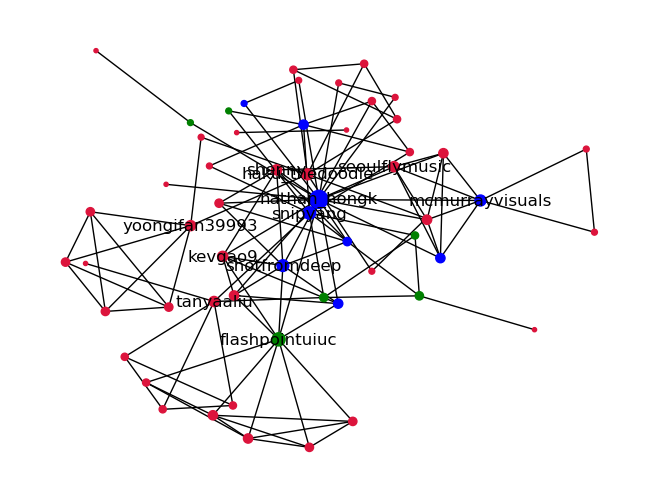

In [25]:
pos=nx.kamada_kawai_layout(G)
nx.draw(G,
        pos=pos,
        node_size = [G.nodes[node]['degree']*500 for node in G.nodes()],
        node_color=[G.nodes[node]['color'] for node in G.nodes()],
        labels={node:node for node in G.nodes() if G.nodes[node]['degree'] > 0.1})

In [26]:
def ego_EI_idx(graph_object):
    EI_dic = {}
    for k in graph_object.nodes:
        external = 0
        internal = 0
        try:
            for i in graph_object.edges(k):
                if graph_object.nodes[i[1]]['role'] == graph_object.nodes[k]['role']:
                    internal += 1
                else:
                    external += 1
        except ZeroDivisionError:
            pass
        if external + internal != 0:
            EI_dic[k] = (external - internal) / (external + internal)
        else:
            EI_dic[k] = 0
    nx.set_node_attributes(graph_object, EI_dic, name="ei_idx")

In [27]:
ego_EI_idx(G)

In [28]:
G.nodes['nathan_hongk'], G.nodes['haku_thedoodle'], G.nodes['flashpointuiuc']

({'role': 'photographer',
  'degree': 0.33928571428571425,
  'betweenness': 0.16515151515151513,
  'closeness': 0.3719387755102041,
  'color': 'blue',
  'ei_idx': 0.3684210526315789},
 {'role': 'other',
  'degree': 0.125,
  'betweenness': 0.023376623376623377,
  'closeness': 0.14404761904761904,
  'color': 'crimson',
  'ei_idx': -1.0},
 {'role': 'rso',
  'degree': 0.17857142857142855,
  'betweenness': 0.07186147186147188,
  'closeness': 0.27697568389057753,
  'color': 'green',
  'ei_idx': 1.0})